<a href="https://colab.research.google.com/github/Moe-phantom/Moe-phantom/blob/main/tabPNF_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -q
!pip install tabpfn[gpu] --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.7/173.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:

# ==============================
# Import after installation
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.impute import SimpleImputer
import warnings
import pickle
import os

warnings.filterwarnings('ignore')

# 🔥 CRITICAL: Import torch AFTER installation to check CUDA
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [3]:
# ==============================
# Configuration
# ==============================
RANDOM_STATE = 42
TEST_SIZE = 0.2
MAX_TRAIN_SIZE = 1024  # TabPFN limit

# ==============================
# Load Data
# ==============================
csv_path = '/content/TOI_2025.09.28_05.51.22.csv'  # UPDATE THIS PATH
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at {csv_path}. Please update the path.")

df = pd.read_csv(csv_path, comment='#')
print(f"Dataset shape: {df.shape}")


Dataset shape: (7699, 27)


In [4]:
# ==============================
# Target & Features
# ==============================
target_col = 'tfopwg_disp'
if target_col not in df.columns:
    possible = [c for c in df.columns if 'disp' in c.lower() or 'class' in c.lower()]
    raise ValueError(f"Target '{target_col}' not found. Candidates: {possible}")

# Feature list
feature_cols = [
    'pl_orbper', 'pl_rade', 'pl_trandep', 'pl_trandur', 'st_tmag',
    'st_rad', 'st_teff', 'st_logg', 'pl_insol', 'pl_eqt',
    'pl_ratdor', 'pl_ratror'
]
snr_cols = [col for col in df.columns if 'snr' in col.lower()]
feature_cols.extend(snr_cols)

# Exclude unwanted
exclude_patterns = ['ra', 'dec', 'tic', 'toi', 'comments', 'flag', 'url', 'date']
available_features = [c for c in feature_cols if c in df.columns]
features_to_use = [c for c in available_features
                   if not any(p in c.lower() for p in exclude_patterns)]

print(f"Using {len(features_to_use)} features: {features_to_use}")



Using 6 features: ['pl_orbper', 'st_tmag', 'st_teff', 'st_logg', 'pl_insol', 'pl_eqt']


In [5]:
X = df[features_to_use].copy()
y = df[target_col].copy()

# Convert to numeric
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing in pl_orbper
if 'pl_orbper' in X.columns:
    X['pl_orbper'].fillna(999, inplace=True)

# Impute rest
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Remove missing targets
mask = ~y.isnull()
X_imputed = X_imputed[mask]
y = y[mask]
print(f"Final dataset shape: {X_imputed.shape}")

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"Classes: {class_names}")

# =

Final dataset shape: (7699, 6)
Classes: ['APC' 'CP' 'FA' 'FP' 'KP' 'PC']


In [6]:
# ==============================
# GPU Setup for TabPFN
# ==============================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

# Import TabPFN AFTER torch is ready
from tabpfn import TabPFNClassifier


Using device: cuda


In [10]:
print("\n" + "="*50)
print("STRATEGY 1: 6-CLASS CLASSIFICATION")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
)

# Subsample if needed
if len(X_train) > MAX_TRAIN_SIZE:
    idx = np.random.choice(len(X_train), MAX_TRAIN_SIZE, replace=False)
    X_train_sub, y_train_sub = X_train.iloc[idx], y_train[idx]
else:
    X_train_sub, y_train_sub = X_train, y_train

# Train TabPFN with GPU
tabpfn = TabPFNClassifier(
    device=device)
print("Training TabPFN (6-class)...")
tabpfn.fit(X_train_sub.values, y_train_sub)  # Use .values for safety

y_pred = tabpfn.predict(X_test.values)
y_proba = tabpfn.predict_proba(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced Accuracy: {balanced_acc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))



STRATEGY 1: 6-CLASS CLASSIFICATION
Training TabPFN (6-class)...


tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Accuracy: 0.649
Balanced Accuracy: 0.249

Classification Report:
              precision    recall  f1-score   support

         APC      0.000     0.000     0.000        92
          CP      0.581     0.182     0.278       137
          FA      0.000     0.000     0.000        19
          FP      0.544     0.364     0.436       239
          KP      0.000     0.000     0.000       117
          PC      0.664     0.949     0.781       936

    accuracy                          0.649      1540
   macro avg      0.298     0.249     0.249      1540
weighted avg      0.540     0.649     0.567      1540



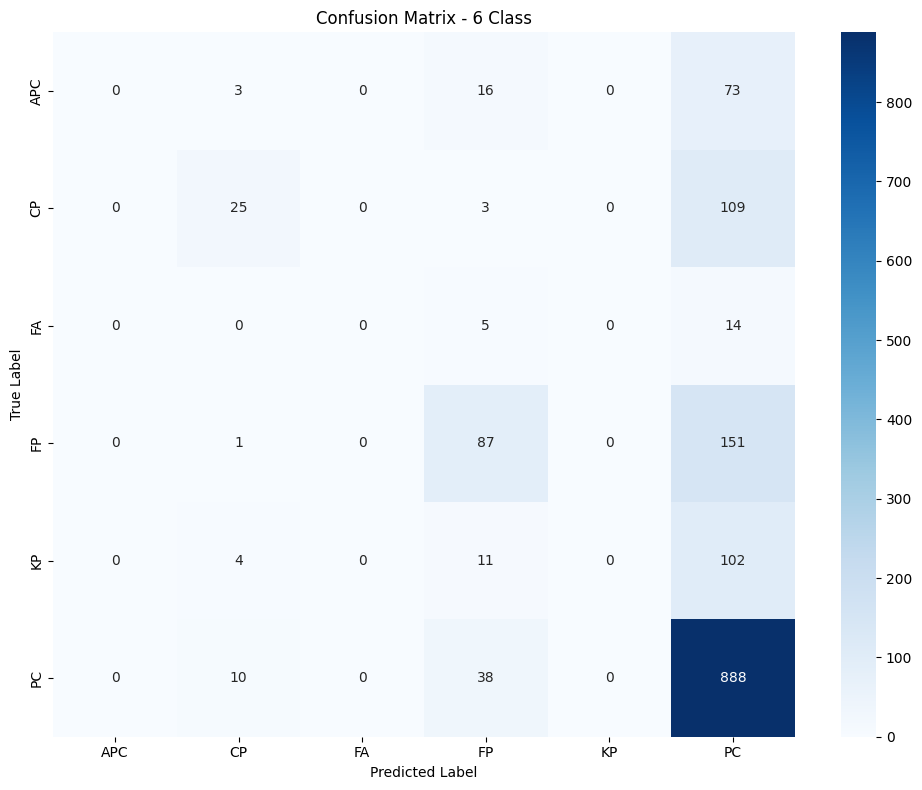

In [11]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - 6 Class')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


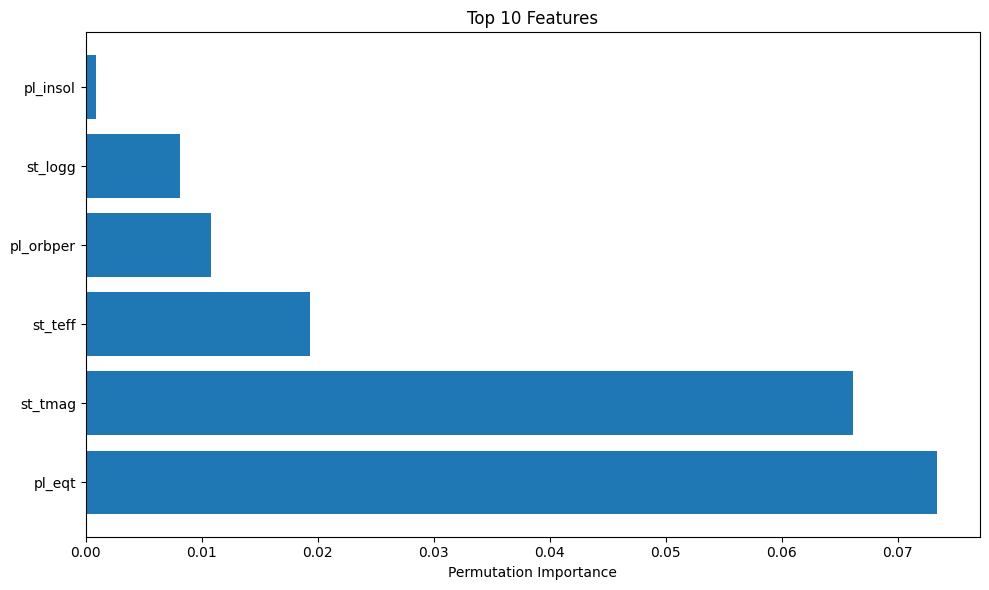

In [12]:
# Feature Importance
from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(tabpfn, X_test.values, y_test, n_repeats=10, random_state=RANDOM_STATE)
feat_imp_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': perm_imp.importances_mean,
    'std': perm_imp.importances_std
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
top10 = feat_imp_df.head(10)
plt.barh(range(len(top10)), top10['importance'])
plt.yticks(range(len(top10)), top10['feature'])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Features')
plt.tight_layout()
plt.show()


In [14]:
# ==============================
# Strategy 2: Binary Classification
# ==============================
print("\n" + "="*50)
print("STRATEGY 2: BINARY CLASSIFICATION")
print("="*50)

planet_classes = ['PC', 'APC', 'CP', 'KP']
y_binary = y.isin(planet_classes).astype(int)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_imputed, y_binary, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_binary
)

if len(X_train_b) > MAX_TRAIN_SIZE:
    idx = np.random.choice(len(X_train_b), MAX_TRAIN_SIZE, replace=False)
    X_train_b_sub, y_train_b_sub = X_train_b.iloc[idx], y_train_b.iloc[idx]
else:
    X_train_b_sub, y_train_b_sub = X_train_b, y_train_b

tabpfn_binary = TabPFNClassifier(device=device)
print("Training binary TabPFN...")
tabpfn_binary.fit(X_train_b_sub.values, y_train_b_sub)

y_pred_b = tabpfn_binary.predict(X_test_b.values)
accuracy_b = accuracy_score(y_test_b, y_pred_b)
balanced_acc_b = balanced_accuracy_score(y_test_b, y_pred_b)

print(f"Binary Accuracy: {accuracy_b:.3f}")
print(f"Balanced Accuracy: {balanced_acc_b:.3f}")



STRATEGY 2: BINARY CLASSIFICATION
Training binary TabPFN...
Binary Accuracy: 0.849
Balanced Accuracy: 0.609


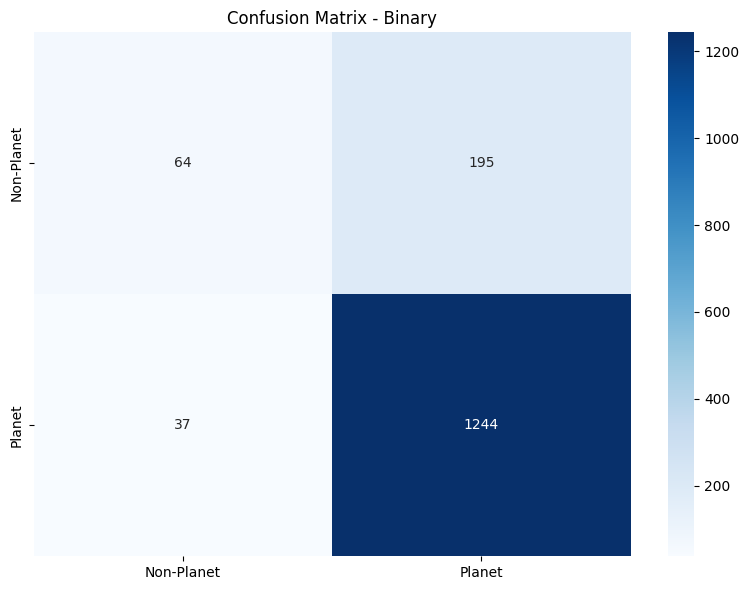

In [15]:
# Binary Confusion Matrix
plt.figure(figsize=(8, 6))
cm_b = confusion_matrix(y_test_b, y_pred_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Planet', 'Planet'], yticklabels=['Non-Planet', 'Planet'])
plt.title('Confusion Matrix - Binary')
plt.tight_layout()
plt.show()


In [16]:
# ==============================
# Save Model
# ==============================
model_artifact = {
    'model': tabpfn_binary,
    'feature_columns': list(X_imputed.columns),
    'imputer': imputer,
    'is_binary': True,
    'accuracy': accuracy_b,
    'balanced_accuracy': balanced_acc_b
}

with open('tabpfn_binary_model.pkl', 'wb') as f:
    pickle.dump(model_artifact, f)

print("\n✅ Model saved to 'tabpfn_binary_model.pkl'")



✅ Model saved to 'tabpfn_binary_model.pkl'


In [17]:
# ==============================
# Final Summary
# ==============================
summary = f"""
TESS TOI Classification Results:
- Device: {device}
- Samples: {len(X_imputed)}
- Features: {len(features_to_use)}
- Planet fraction: {y_binary.mean():.1%}
- Binary Accuracy: {accuracy_b:.1%}
- Top feature: {feat_imp_df.iloc[0]['feature']}
"""
print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(summary)


SUMMARY

TESS TOI Classification Results:
- Device: cuda
- Samples: 7699
- Features: 6
- Planet fraction: 83.2%
- Binary Accuracy: 84.9%
- Top feature: pl_eqt

